### AI3000: Reinforcement Learning

#### Assignment 4

#### Tanmay Goyal

#### AI20BTECH11021

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random

##### 1. Deep Q Networks

In [199]:
env = gym.make("MountainCar-v0")
print("MOUNTAINCAR-V0")
print("Three actions: Accelerate to the left , Dont Accelerate and Accelerate to the right -> " , env.action_space)
print("State space comprises of position of car along x axis and velocity of car  -> ", env.observation_space) 
print("How the step function looks like:")
for k in range(10):
    action = np.random.randint(0,3)
    env.reset()
    next_set = env.step(action)
    observation = next_set[0]
    reward = next_set[1]
    terminated = next_set[2]
    print("Observation -> " , observation)
    print("Reward -> ", reward)
    print("Terminated -> ",terminated)

MOUNTAINCAR-V0
Three actions: Accelerate to the left , Dont Accelerate and Accelerate to the right ->  Discrete(3)
State space comprises of position of car along x axis and velocity of car  ->  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
How the step function looks like:
Observation ->  [-5.8036470e-01  4.2684434e-04]
Reward ->  -1.0
Terminated ->  False
Observation ->  [-0.45714146 -0.0015062 ]
Reward ->  -1.0
Terminated ->  False
Observation ->  [-4.0955824e-01  1.6243152e-04]
Reward ->  -1.0
Terminated ->  False
Observation ->  [-0.47137824 -0.00140043]
Reward ->  -1.0
Terminated ->  False
Observation ->  [-0.47940758  0.00067455]
Reward ->  -1.0
Terminated ->  False
Observation ->  [-0.5117997  -0.00109669]
Reward ->  -1.0
Terminated ->  False
Observation ->  [-5.2425396e-01  4.9510863e-06]
Reward ->  -1.0
Terminated ->  False
Observation ->  [-0.4626007  -0.00146574]
Reward ->  -1.0
Terminated ->  False
Observation ->  [-0.48667413 -0.00128595]
Reward ->  -1.0
Terminated ->  Fa

In [200]:
env = gym.make("ALE/Pong-v5")
print("PONG-V5")
print("Six actions: NOOP , Fire , Right , Left , RightFire , LeftFire -> " , env.action_space)
print("State space comprises all RGB images -> ", env.observation_space) 
print("How the step function looks like:")
for k in range(10):
    action = np.random.randint(0,6)
    env.reset()
    next_set = env.step(action)
    observation = next_set[0]
    reward = next_set[1]
    terminated = next_set[2]
    print("Observation shape -> " , np.array(observation).shape)
    print("Reward -> ", reward)
    print("Terminated -> ",terminated)

PONG-V5
Six actions: NOOP , Fire , Right , Left , RightFire , LeftFire ->  Discrete(6)
State space comprises all RGB images ->  Box(0, 255, (210, 160, 3), uint8)
How the step function looks like:
Observation shape ->  (210, 160, 3)
Reward ->  0.0
Terminated ->  False
Observation shape ->  (210, 160, 3)
Reward ->  0.0
Terminated ->  False
Observation shape ->  (210, 160, 3)
Reward ->  0.0
Terminated ->  False
Observation shape ->  (210, 160, 3)
Reward ->  0.0
Terminated ->  False
Observation shape ->  (210, 160, 3)
Reward ->  0.0
Terminated ->  False
Observation shape ->  (210, 160, 3)
Reward ->  0.0
Terminated ->  False
Observation shape ->  (210, 160, 3)
Reward ->  0.0
Terminated ->  False
Observation shape ->  (210, 160, 3)
Reward ->  0.0
Terminated ->  False
Observation shape ->  (210, 160, 3)
Reward ->  0.0
Terminated ->  False
Observation shape ->  (210, 160, 3)
Reward ->  0.0
Terminated ->  False


In [2]:
class Q_Network(nn.Module):

    def __init__(self , state_size , action_size):
        super(Q_Network , self).__init__()
        self.L1 = nn.Linear(state_size , 128)
        self.L2 = nn.Linear(128,256)
        self.L3 = nn.Linear(256 , action_size)

    def forward(self , x):
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        x = self.L3(x)
        return x

In [3]:
BUFFER_LENGTH = 100000
EPSILON = 1.0
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.001
GAMMA = 0.999
BATCH_SIZE = 64
UPDATE_TARGET = 5

class DQN():

    def __init__(self , state_size , action_size):
        # initialising model, target model , replay buffer
        self.model = Q_Network(state_size , action_size)
        self.target_model = Q_Network(state_size , action_size)

        self.optimizer = torch.optim.Adam(self.model.parameters() , lr = 0.001)

        self.memory = deque(maxlen = BUFFER_LENGTH)

        self.step = 0

    def action(self , state , action_size):
        # sample action using epsilon-greedy
        state = torch.tensor(state)
        self.model.eval()
        
        with torch.no_grad():
            Q = self.model(state)
        
        self.model.train()
        
        policy = np.array([EPSILON / action_size for i in range(action_size)])
        policy[np.argmax(Q.data.numpy())] += 1 - EPSILON
        return np.random.choice(action_size , 1 , p = policy)[0]

    def replay_memory(self , transition):
        # checking if we can begin training if our replay memory has sufficient samples
        self.memory.append(transition)
        
        if len(self.memory) < BUFFER_LENGTH:
            return 
        else:
            self.train() 


    def train(self):
        experience = random.sample(self.memory , BATCH_SIZE)
        
        criterion = torch.nn.MSELoss()
        
        self.model.train()
        self.target_model.eval()


        current_states = torch.tensor([transition[0].tolist() for transition in experience])
        actions = torch.tensor([transition[1] for transition in experience])
        reward = torch.tensor([transition[2] for transition in experience])        
        next_states = torch.tensor([transition[3] for transition in experience])
        done = torch.tensor([transition[-1] for transition in experience])

        predicted_q = self.model(current_states)

        with torch.no_grad():
            print(next_states)
            next_q = self.target_model(next_states).detach()

        labels = []
        for index , q_state in enumerate(next_q):
            if done[index]:
                labels.append(reward[index].item())
            else:
                labels.append([reward[index].item() + GAMMA * q_state.max() for i in range(len(q_state))])
        
        loss = criterion(predicted_q , torch.tensor(labels))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.step += 1

        if self.step % UPDATE_TARGET == 0:
            for target_param, local_param in zip(self.target_model.parameters(),self.model.parameters()):
                target_param.data.copy_(local_param.data)



        

Episode  0


/var/folders/x0/r7576wrd5w3dfxhxvxn3v81w0000gn/T/ipykernel_1818/918888696.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state)


Episode  20
Episode  40
Episode  60
Episode  80
Episode  100
Episode  120
Episode  140
Episode  160
Episode  180
Episode  200
Episode  220
Episode  240
Episode  260
Episode  280
Episode  300
Episode  320
Episode  340
Episode  360
Episode  380
Episode  400
Episode  420
Episode  440
Episode  460
Episode  480
Episode  500
Episode  520
Episode  540
Episode  560
Episode  580
Episode  600
Episode  620
Episode  640
Episode  660
Episode  680
Episode  700
Episode  720
Episode  740
Episode  760
Episode  780
Episode  800
Episode  820
Episode  840
Episode  860
Episode  880
Episode  900
Episode  920
Episode  940
Episode  960
Episode  980
Episode  1000
Episode  1020
Episode  1040
Episode  1060
Episode  1080
Episode  1100
Episode  1120
Episode  1140
Episode  1160
Episode  1180
Episode  1200
Episode  1220
Episode  1240
Episode  1260
Episode  1280
Episode  1300
Episode  1320
Episode  1340
Episode  1360
Episode  1380
Episode  1400
Episode  1420
Episode  1440
Episode  1460
Episode  1480
Episode  1500
Epi

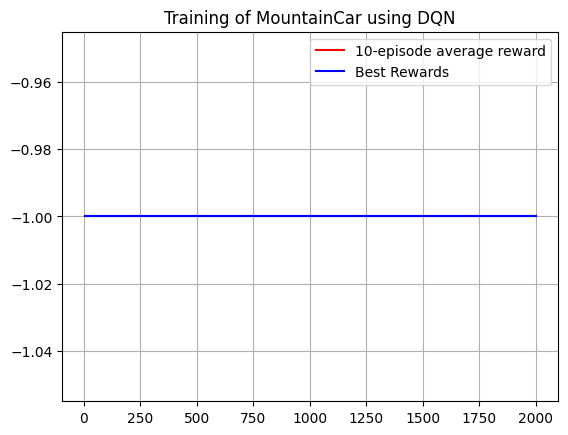

In [203]:
env = gym.make("MountainCar-v0")

agent = DQN(2 , 2)
avg_rewards = []
best_rewards = []

for episode in range(2000):     # We take number of episodes as 2000
    if episode % 20 == 0:
        print("Episode ", episode)
    state = env.reset()[0]
    episode_score = 0

    for t in range(1000):   # Number of time steps = 1000
        state = torch.tensor(state)
        agent.model.eval()
        
        with torch.no_grad():
            Q = agent.model(state)
        
        agent.model.train()

        action = Q.argmax().item()
        
        next_set = env.step(action)
        next_state = next_set[0]
        reward = next_set[1]
        done = next_set[2]

        agent.replay_memory([state , action , reward , next_state , done])

        episode_score += reward

        if done:
            break
        
        EPSILON = max(EPSILON * EPSILON_DECAY , MIN_EPSILON)   

    if episode % UPDATE_TARGET == 0:
        agent.model.eval()
        rewards = []

        for test_episode in range(10):
            
            for t in range(1000):
                state = env.reset()[0]
                episode_score = 0
                action = agent.action(state , 2)
                
                next_set = env.step(action)
                next_state = next_set[0]
                reward = next_set[1]
                done = next_set[2]

                episode_score += reward

                if done:
                    break

            rewards.append(episode_score)

        rewards = np.array(rewards)
        avg_rewards.append(np.mean(rewards))
        best_rewards.append(np.max(rewards))

    agent.model.train()

x = np.arange(5 , 2005 , 5)
plt.plot(x , avg_rewards , 'r-' , label = "10-episode average reward")
plt.plot(x , best_rewards , 'b-' , label = "Best Rewards")
plt.title("Training of MountainCar using DQN")
plt.grid(True)
plt.legend()
plt.show()

##### c) Changing the Hyperparameters

Since the training never converges, we will get the same graphs. However, we change the number of episodes and observe the same.

/var/folders/x0/r7576wrd5w3dfxhxvxn3v81w0000gn/T/ipykernel_1818/768008847.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state)


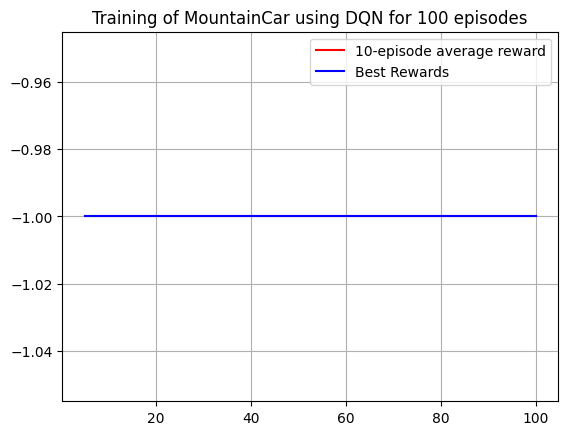

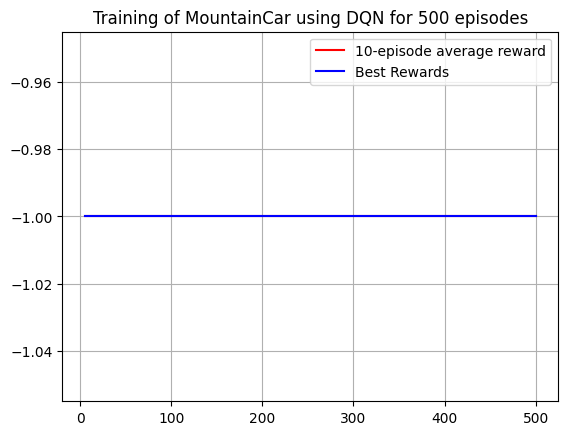

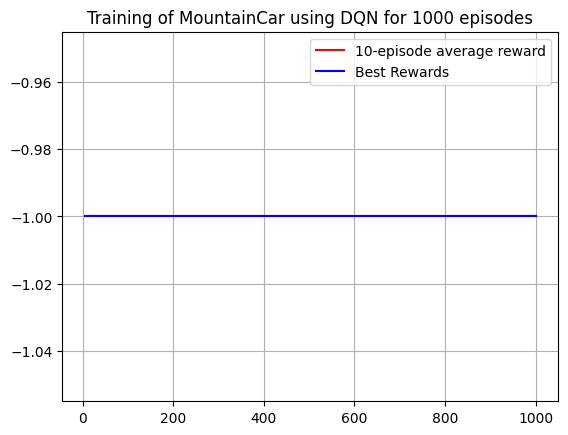

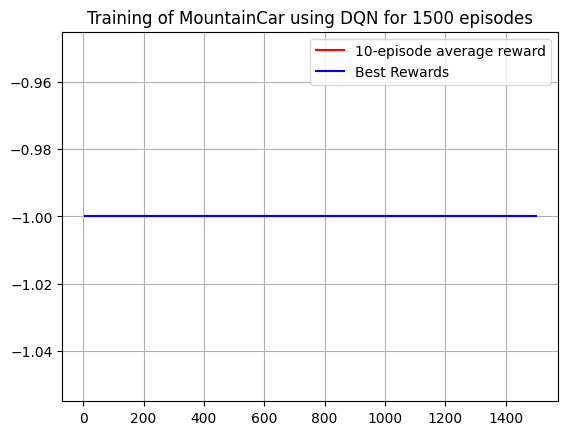

In [210]:
episodes = [100 , 500 , 1000 , 1500]

for n_episodes in episodes:

    env = gym.make("MountainCar-v0")

    agent = DQN(2 , 2)
    avg_rewards = []
    best_rewards = []

    for episode in range(n_episodes):     # We take number of episodes as 2000
        state = env.reset()[0]
        episode_score = 0

        for t in range(1000):   # Number of time steps = 1000
            state = torch.tensor(state)
            agent.model.eval()
            
            with torch.no_grad():
                Q = agent.model(state)
            
            agent.model.train()

            action = Q.argmax().item()
            
            next_set = env.step(action)
            next_state = next_set[0]
            reward = next_set[1]
            done = next_set[2]

            agent.replay_memory([state , action , reward , next_state , done])

            episode_score += reward

            if done:
                break
            
            EPSILON = max(EPSILON * EPSILON_DECAY , MIN_EPSILON)   

        if episode % UPDATE_TARGET == 0:
            agent.model.eval()
            rewards = []

            for test_episode in range(10):
                
                for t in range(1000):
                    state = env.reset()[0]
                    episode_score = 0
                    action = agent.action(state , 2)
                    
                    next_set = env.step(action)
                    next_state = next_set[0]
                    reward = next_set[1]
                    done = next_set[2]

                    episode_score += reward

                    if done:
                        break

                rewards.append(episode_score)

            rewards = np.array(rewards)
            avg_rewards.append(np.mean(rewards))
            best_rewards.append(np.max(rewards))

        agent.model.train()

    x = np.arange(5 , n_episodes + 5 , 5)
    plt.plot(x , avg_rewards , 'r-' , label = "10-episode average reward")
    plt.plot(x , best_rewards , 'b-' , label = "Best Rewards")
    plt.title("Training of MountainCar using DQN for {} episodes".format(n_episodes))
    plt.grid(True)
    plt.legend()
    plt.show()

In [4]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet , self).__init__()
        self.conv1 = nn.Conv2d(3 , 32 , 5)  
        self.conv2 = nn.Conv2d(32 , 64 , 5)
        self.conv3 = nn.Conv2d(64 , 3 , 5)
        self.pool = nn.MaxPool2d(2 , 2) 

    def forward(self , X):
        X = F.relu(self.conv1(X))
        X = self.pool(X)
        X = F.relu(self.conv2(X))
        X = self.pool(X)
        X = F.relu(self.conv3(X))
        X = self.pool(X)
        return X
        


In [5]:
env = gym.make("ALE/Pong-v5")
conv = ConvNet()
state = env.reset()[0].transpose(2 , 0 , 1)
sample_output = conv(torch.FloatTensor(state))
h,w,c = sample_output.shape
agent = DQN(h * w * c, 6)


avg_rewards = []
best_rewards = []

for episode in range(2000):     # We take number of episodes as 2000
    if episode % 20 == 0:
        print("Episode ", episode)
    state = env.reset()[0].transpose(2 , 0 , 1)
    state = conv(torch.FloatTensor(state))
    state = state.reshape((1 , h * w * c))
    episode_score = 0

    for t in range(1000):   # Number of time steps = 1000
        # state = torch.FloatTensor(state)
        agent.model.eval()
        
        with torch.no_grad():
            Q = agent.model(state)
        
        agent.model.train()

        action = Q.argmax().item()
        
        next_set = env.step(action)
        next_state = next_set[0]
        reward = next_set[1]
        done = next_set[2]
        
        next_state = next_state.transpose(2,0,1)
        next_state = conv(torch.FloatTensor(next_state))
        next_state = next_state.reshape((1 , h * w * c))

        agent.replay_memory([state , action , reward , next_state , done])

        episode_score += reward

        if done:
            break
        
        EPSILON = max(EPSILON * EPSILON_DECAY , MIN_EPSILON)   

    if episode % UPDATE_TARGET == 0:
        agent.model.eval()
        rewards = []

        for test_episode in range(10):
            
            for t in range(1000):
                state = env.reset()[0].transpose(2 , 0 , 1)
                state = conv(torch.FloatTensor(state))
                state = state.reshape((1 , h * w * c))
                episode_score = 0
                action = agent.action(state , 6)
                
                next_set = env.step(action)
                next_state = next_set[0]
                reward = next_set[1]
                done = next_set[2]

                episode_score += reward

                if done:
                    break

            rewards.append(episode_score)

        rewards = np.array(rewards)
        avg_rewards.append(np.mean(rewards))
        best_rewards.append(np.max(rewards))

    agent.model.train()

x = np.arange(5 , 2005 , 5)
plt.plot(x , avg_rewards , 'r-' , label = "10-episode average reward")
plt.plot(x , best_rewards , 'b-' , label = "Best Rewards")
plt.title("Training of Pong using DQN")
plt.grid(True)
plt.legend()
plt.show()


A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


Episode  0


/var/folders/x0/r7576wrd5w3dfxhxvxn3v81w0000gn/T/ipykernel_26876/3852295500.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state)


Episode  20


: 

: 

##### 3. Policy Gradient


In [ ]:
env = gym.make("CartPole-v1")
print("CARTPOLE-V0")
print("Two actions: left and right -> " , env.action_space)
print("State space comprises of position, velocity , angle, angular velocity -> ", env.observation_space) 
print("How the step function looks like:")
for k in range(10):
    action = np.random.randint(0,2)
    env.reset()
    next_set = env.step(action)
    observation = next_set[0]
    reward = next_set[1]
    terminated = next_set[2]
    print("Observation -> ", observation)
    print("Reward -> ", reward)
    print("Terminated -> ",terminated)

CARTPOLE-V0
Two actions: left and right ->  Discrete(2)
State space comprises of position, velocity , angle, angular velocity ->  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
How the step function looks like:
Observation ->  [ 0.03650697 -0.22606766  0.04338955  0.3513899 ]
Reward ->  1.0
Terminated ->  False
Observation ->  [-0.02765901  0.1707721  -0.0038573  -0.30455467]
Reward ->  1.0
Terminated ->  False
Observation ->  [-0.04315016 -0.20642352  0.02726621  0.3235166 ]
Reward ->  1.0
Terminated ->  False
Observation ->  [-0.04035915 -0.24384482 -0.00219032  0.32750574]
Reward ->  1.0
Terminated ->  False
Observation ->  [-0.04397425  0.19237946 -0.01585678 -0.3127662 ]
Reward ->  1.0
Terminated ->  False
Observation ->  [ 0.00669618  0.17164671 -0.00647332 -0.3005347 ]
Reward ->  1.0
Terminated ->  False
Observation ->  [ 0.04326451 -0.24085453  0.0336575   0.31975207]
Reward ->  1.0
Te

In [ ]:
env = gym.make("LunarLander-v2")
env.reset()
print("LUNAR LANDER")
print("Actions are: Nop, fire left engine, main engine, right engine -> ",env.action_space)
print("Observation space consists of x  , y , velocity in x , velocity in y , angle, angular velocity ,  left leg in contact with ground , right leg in contact with ground -> \n",env.observation_space)
print("How the step function looks like:")
for k in range(10):
    action = np.random.randint(0,4)
    env.reset()
    next_set = env.step(action)
    observation = next_set[0]
    reward = next_set[1]
    terminated = next_set[2]
    print("Observation -> ", observation)
    print("Reward -> ", reward)
    print("Terminated -> ",terminated)


LUNAR LANDER
Actions are: Nop, fire left engine, main engine, right engine ->  Discrete(4)
Observation space consists of x  , y , velocity in x , velocity in y , angle, angular velocity ,  left leg in contact with ground , right leg in contact with ground -> 
 Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
How the step function looks like:
Observation ->  [-0.00287857  1.3874478  -0.15114261 -0.534601    0.0050873   0.06912473
  0.          0.        ]
Reward ->  -1.9201957580444844
Terminated ->  False
Observation ->  [ 0.00795469  1.3902162   0.4094432  -0.47282332 -0.01140283 -0.13713758
  0.          0.        ]
Reward ->  -2.3194586814196314
Terminated ->  False
Observation ->  [ 0.0070837   1.4310535   0.35361248  0.43430394 -0.00662654 -0.04987082
  0.          0.        ]
Reward ->  1.3038122508632182
Terminated ->  False
Observation ->  [-0.0048

In [4]:
class PolicyNet(nn.Module):

    def __init__(self , state_size , action_size):
        super(PolicyNet , self).__init__()
        self.L1 = nn.Linear(in_features = state_size , out_features = 128)
        self.L2 = nn.Linear(in_features = 128 , out_features = 256)
        self.L3 = nn.Linear(in_features = 256 , out_features = action_size)

    def forward(self , x):
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        x = F.softmax(self.L3(x) , dim = -1)
        return x

In [27]:
GAMMA = 0.99

def VanillaPolicyGradient(env , state_size , action_size , horizons, batch_size, episode_length, reward_to_go , advantage_normalization):

    policy = PolicyNet(state_size , action_size)
    optimizer = torch.optim.Adam(policy.parameters() , lr = 0.001)
    performance_rewards = []

    for n in range(horizons):
        if n % 100 == 0:
            print("Epoch ", n)
        episodes_states = []
        episodes_rewards = []
        episodes_actions = []

        for episode in range(batch_size):
            curr_state = env.reset()[0]

            state = []
            reward = []
            action = []
            if episode_length == "True":
                while True:
                    prob = policy(torch.tensor(curr_state)).detach().numpy()

                    a = np.random.choice(action_size , 1 , prob.data)[0]

                    next_state , r , done , _ , _ = env.step(a)

                    state.append(next_state)
                    reward.append(r)
                    action.append(a)
                    curr_state = next_state
                    
                    if done:
                        episodes_states.append(state)
                        episodes_rewards.append(reward)
                        episodes_actions.append(action)
                        break
            else:
                length = int(episode_length)

                for i in range(length):
                    prob = policy(torch.tensor(curr_state)).detach().numpy()

                    a = np.random.choice(action_size , 1 , prob.data)[0]

                    next_state , r , done , _ , _ = env.step(a)

                    state.append(next_state)
                    reward.append(r)
                    action.append(a)
                    curr_state = next_state
                    
                    if done:
                        break
                episodes_states.append(state)
                episodes_rewards.append(reward)
                episodes_actions.append(action)
            
        if reward_to_go:
            R  = [np.array([np.sum(np.array(X[i:])) for i in range(len(X))]) for X in episodes_rewards]
            discounts = [np.array([GAMMA ** i for i in range(len(X))]) for X in episodes_rewards]
            G = [np.dot(R[i] , discounts[i]) for i in range(len(R))]
        else:
            R  = [np.array([np.sum(np.array(X)) for i in range(len(X))]) for X in episodes_rewards]
            discounts = [np.array([GAMMA ** i for i in range(len(X))]) for X in episodes_rewards]
            G = [np.dot(R[i] , discounts[i]) for i in range(len(R))]

        # we use constant baseline
        b = np.mean(np.array([np.sum(np.array(X)) for X in episodes_rewards]))
        
        A_dash = G - b

        if advantage_normalization:
            A = np.array([(np.array(X) - np.mean(np.array(X)) / (np.var(np.array(X)) + 0.00001)) for X in A_dash])

        else:
            A = A_dash
    
        optimizer.zero_grad()
        loss = 0
        for i in range(len(episodes_states)):
            for j in range(len(episodes_states[i])):
                loss += -torch.log(policy(torch.tensor(episodes_states[i][j]))) * A[i]
        loss.sum().backward()
        optimizer.step()

        if n % 10 == 0:
            test_rewards = []
            
            for e in range(10):
                reward = []
                curr_state = env.reset()[0]

                if episode_length == "True":
                    while True:
                        prob = policy(torch.tensor(curr_state)).detach().numpy()

                        a = np.random.choice(action_size , 1 , prob.data)[0]

                        next_state , r , done , _ , _ = env.step(a)

                        reward.append(r)
                        curr_state = next_state
                        
                        if done:
                            test_rewards.append(np.sum(np.array(reward)))
                            break
                else:
                    length = int(episode_length)

                    for i in range(length):
                        prob = policy(torch.tensor(curr_state)).detach().numpy()

                        a = np.random.choice(action_size , 1 , prob.data)[0]

                        next_state , r , done , _ , _ = env.step(a)

                        reward.append(r)
                        curr_state = next_state
                        
                        if done:
                            break
                        
                    test_rewards.append(np.sum(np.array(reward)))
            
            performance_rewards.append(np.mean(np.array(test_rewards)))
    return performance_rewards


Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
Epoch  500
Epoch  600
Epoch  700
Epoch  800
Epoch  900
Epoch  1000
Epoch  1100
Epoch  1200
Epoch  1300
Epoch  1400
Epoch  1500
Epoch  1600
Epoch  1700
Epoch  1800
Epoch  1900
Epoch  2000
Epoch  2100
Epoch  2200
Epoch  2300
Epoch  2400
Epoch  2500
Epoch  2600
Epoch  2700
Epoch  2800
Epoch  2900
Epoch  3000
Epoch  3100
Epoch  3200
Epoch  3300
Epoch  3400
Epoch  3500
Epoch  3600
Epoch  3700
Epoch  3800
Epoch  3900
Epoch  4000
Epoch  4100
Epoch  4200
Epoch  4300
Epoch  4400
Epoch  4500
Epoch  4600
Epoch  4700
Epoch  4800
Epoch  4900
Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
Epoch  500
Epoch  600
Epoch  700
Epoch  800
Epoch  900
Epoch  1000
Epoch  1100
Epoch  1200
Epoch  1300
Epoch  1400
Epoch  1500
Epoch  1600
Epoch  1700
Epoch  1800
Epoch  1900
Epoch  2000
Epoch  2100
Epoch  2200
Epoch  2300
Epoch  2400
Epoch  2500
Epoch  2600
Epoch  2700
Epoch  2800
Epoch  2900
Epoch  3000
Epoch  3100
Epoch  3200
Epoch  3300
Epoch  3400
Epoc

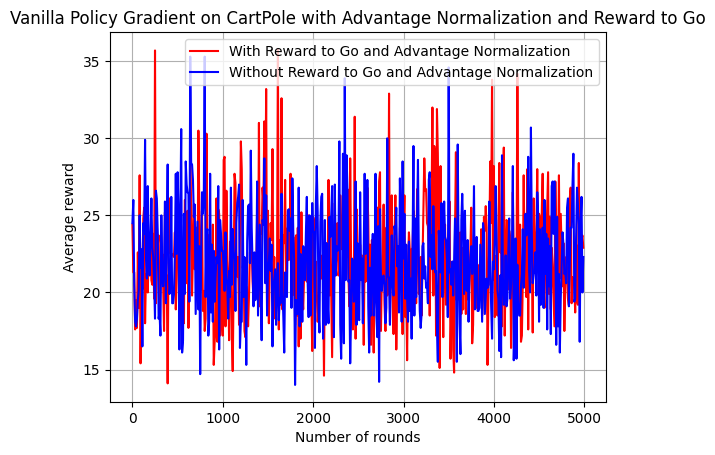

In [13]:
env = gym.make("CartPole-v1")
rewards_with = VanillaPolicyGradient(env , 4 , 2 , 5000 , 500, "True" , True , True)
rewards_without = VanillaPolicyGradient(env , 4 , 2 ,5000, 500, "True" , False , False)
x = np.arange(0,5000,10)
plt.plot(x , rewards_with , 'r-' , label = "With Reward to Go and Advantage Normalization")
plt.plot(x , rewards_without , 'b-' , label = "Without Reward to Go and Advantage Normalization")
plt.grid(True)
plt.legend()
plt.xlabel("Number of rounds")
plt.ylabel("Average reward")
plt.title("Vanilla Policy Gradient on CartPole with Advantage Normalization and Reward to Go")
plt.show()

Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
Epoch  500
Epoch  600
Epoch  700
Epoch  800
Epoch  900
Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
Epoch  500
Epoch  600
Epoch  700
Epoch  800
Epoch  900


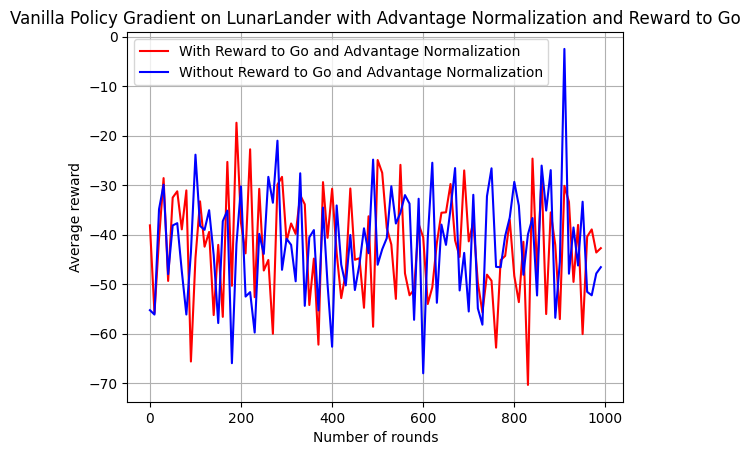

In [28]:
env = gym.make("LunarLander-v2")
rewards_with = VanillaPolicyGradient(env ,8,4 ,1000, 100, "50", True , True)
rewards_without = VanillaPolicyGradient(env ,8,4 ,1000, 100, "50", False , False)
x = np.arange(0,1000,10)
plt.plot(x , rewards_with , 'r-' , label = "With Reward to Go and Advantage Normalization")
plt.plot(x , rewards_without , 'b-' , label = "Without Reward to Go and Advantage Normalization")
plt.grid(True)
plt.legend()
plt.xlabel("Number of rounds")
plt.ylabel("Average reward")
plt.title("Vanilla Policy Gradient on LunarLander with Advantage Normalization and Reward to Go")
plt.show()

##### c) Impact of Batch Size

We find that as the batch size increases, the peak of average reward obtained over the iterations also increases. Also, as the batch size increases, we find that the range between which the average rewards vary also increases.

Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
Epoch  500
Epoch  600
Epoch  700
Epoch  800
Epoch  900
Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
Epoch  500
Epoch  600
Epoch  700
Epoch  800
Epoch  900
Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
Epoch  500
Epoch  600
Epoch  700
Epoch  800
Epoch  900
Epoch  0
Epoch  100
Epoch  200
Epoch  300
Epoch  400
Epoch  500
Epoch  600
Epoch  700
Epoch  800
Epoch  900


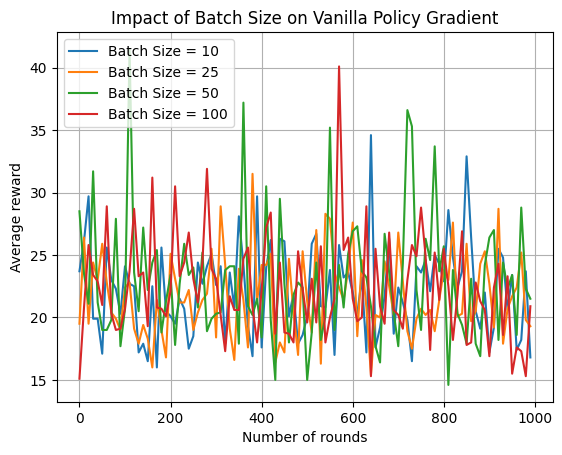

In [29]:
batches = [10 , 25 , 50 , 100]

for b in batches:
    env = gym.make("CartPole-v1")
    rewards_with = VanillaPolicyGradient(env , 4 , 2 , 1000 , b, "True" , True , True)
    x = np.arange(0,1000,10)
    plt.plot(x , rewards_with , label = "Batch Size = {}".format(b))
plt.grid(True)
plt.legend()
plt.xlabel("Number of rounds")
plt.ylabel("Average reward")
plt.title("Impact of Batch Size on Vanilla Policy Gradient")
plt.show()